This project is only for learning purposes , the dataset is really limited (100 images of Covid19 infected xrays and  108 images of healthy xrays) , in this project i'm gonna try using different techniques for the sake of testing and getting familiar with multiple concepts : data augmentation , decaying learning rate , transfer learning , dropout regularization...

The data distribution is the following: Total = 208 images ; Training = 144 images ; Validation = 36 images ; Test = 28 images

i'll be doing this in 4 steps:

-Machine learning algorithms (LogisticRegression and SVM)

-a simple CNN architecture

-transfer learning from VGG16 and fine-tune the output

-transfer learning from ResNet50 and fine-tune output

In [179]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [180]:
# image sizes used to train models
IMG_WIDTH=214
IMG_HEIGHT=214
# initializing some hyperparameters
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [181]:
# Preparing the data for the Neural Networks later on
print("[INFO] loading train and validation images...")
imagePaths = list(paths.list_images('./TrainAndValid'))
data = []
labels = []
for imagePath in imagePaths:
    # extract the class label
    label = imagePath.split(os.path.sep)[-2]
    # swap color channels and resize images to IMG_HEIGHTxIMG_WIDTH
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)
# checking shapes
print("X shape is :",data.shape)
print("Y shape is :",labels.shape)

[INFO] loading train and validation images...
X shape is : (180, 214, 214, 3)
Y shape is : (180,)


In [182]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and validation splits 70-30
(trainX, ValidX, trainY, ValidY) = train_test_split(data, labels,test_size=0.3, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

In [183]:
print("Training shape is :",trainX.shape)
print("Validation shape is :",ValidX.shape)

Training shape is : (126, 214, 214, 3)
Validation shape is : (54, 214, 214, 3)


In [184]:
# prepare data for Machine learning algorithms
binaryLabels=[]
for i,label in enumerate(labels):
    if label[0]==1:
        binaryLabels.append(1)
    else:
        binaryLabels.append(0)
binaryLabels=np.array(binaryLabels)
# partition the data into training and validation splits 70-30 
(trainX_ML, ValidX_ML, trainY_ML, ValidY_ML) = train_test_split(data, binaryLabels,test_size=0.3, stratify=binaryLabels, random_state=42)
# flatten each image HEIGHTxWIDTHx3 to a vector of features
trainX_flatten = trainX_ML.reshape(trainX_ML.shape[0], -1)
ValidX_flatten = ValidX_ML.reshape(ValidX_ML.shape[0], -1)
print(trainX_flatten.shape)
print(ValidX_flatten.shape)
print(trainY_ML.shape)

(126, 137388)
(54, 137388)
(126,)


In [185]:
# Step 1 : Machine learning algorithms (Validation set is used for testing here (Accuracy and predictions))
# Logistic regression classifier
clf = LogisticRegression(random_state=0).fit(trainX_flatten, trainY_ML)
print("Accuracy:",clf.score(ValidX_flatten,ValidY_ML))
print("Predictions :")
print(clf.predict(ValidX_flatten))
print("Actual Labels :")
print(ValidY_ML)

D:\Users\Shintaki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.9814814814814815
Predictions :
[0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0]
Actual Labels :
[0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0]


In [186]:
# SVC classifier
clf = SVC(gamma='auto')
clf.fit(trainX_flatten, trainY_ML)
print("Accuracy :",clf.score(ValidX_flatten,ValidY_ML))
print("Predictions :")
print(clf.predict(ValidX_flatten))
print("Actual Labels :")
print(ValidY_ML)

Accuracy : 0.9814814814814815
Predictions :
[0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0]
Actual Labels :
[0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0]


In [187]:
# Step 2 : a simple CNN
model =Sequential()
model.add(layers.Conv2D(32, (3, 3), padding="same",activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D((8, 8),padding="same",strides=(8,8)))
model.add(layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
model.add(layers.MaxPooling2D((4, 4),padding="same",strides=(4,4)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation="softmax"))
model.summary()
# using Adam optimizing algorithm with decaying learning rate
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history1 = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(ValidX, ValidY),
    validation_steps=len(ValidX) // BS,
    epochs=EPOCHS)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 214, 214, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               1606144   
_________________________________________________________________
dense_32 (Dense)             (None, 64)              

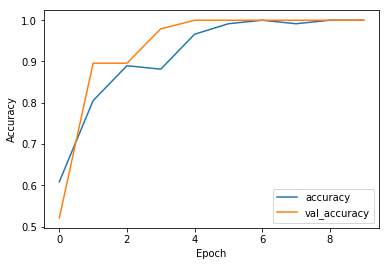

In [188]:
# plotting Accuracy
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

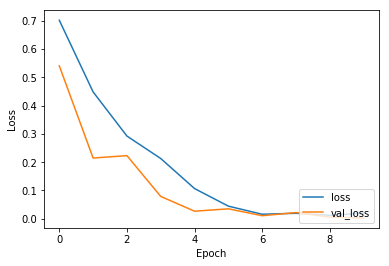

In [189]:
# plotting loss
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [190]:
# Preparing Test data
print("[INFO] loading test images...")
testPaths = list(paths.list_images('./Test'))
testX = []
testY = []
# loop over the image paths
for imagePath in testPaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # swap color channels and resize images to 512x512
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    # update the data and labels lists, respectively
    testX.append(image)
    testY.append(label)
# intensities to the range [0, 1]
testX = np.array(testX) / 255.0
testY = np.array(testY)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
testY = lb.fit_transform(testY)
testY = to_categorical(testY)
# checking the shapes
print(testX.shape)
print(testY.shape)
# Evaluating model
print("Evaluation :")
test_loss, test_acc = model.evaluate(testX,  testY)
# showing the predictions on the test images (14 positive images and 14 negative images)
print("Predictions :")
Yhat=model.predict(testX)
for i in range(len(testX)):
    print("Test number ",i," Prediction: ",Yhat[i]," Label: ",testY[i]) 

[INFO] loading test images...
(28, 214, 214, 3)
(28, 2)
Evaluation :
28/28 [==============================] - 0s 3ms/sample - loss: 0.1037 - accuracy: 0.9643
Predictions :
Test number  0  Prediction:  [9.9998069e-01 1.9279973e-05]  Label:  [1. 0.]
Test number  1  Prediction:  [9.9959332e-01 4.0669582e-04]  Label:  [1. 0.]
Test number  2  Prediction:  [9.9996078e-01 3.9271294e-05]  Label:  [1. 0.]
Test number  3  Prediction:  [9.9957269e-01 4.2728893e-04]  Label:  [1. 0.]
Test number  4  Prediction:  [9.9996519e-01 3.4849476e-05]  Label:  [1. 0.]
Test number  5  Prediction:  [9.999068e-01 9.319648e-05]  Label:  [1. 0.]
Test number  6  Prediction:  [0.05995192 0.94004804]  Label:  [1. 0.]
Test number  7  Prediction:  [0.9197652  0.08023486]  Label:  [1. 0.]
Test number  8  Prediction:  [9.9992466e-01 7.5275399e-05]  Label:  [1. 0.]
Test number  9  Prediction:  [9.9998665e-01 1.3403719e-05]  Label:  [1. 0.]
Test number  10  Prediction:  [9.999391e-01 6.089330e-05]  Label:  [1. 0.]
Test nu

In [191]:
# Step 3: transfer learning with VGG16
# Loading VGG model
baseModelVGG = VGG16(weights="imagenet", include_top=False,input_tensor=layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
print("Model loaded")
# Putting Pool => FC => dropout => softmax on top of it
modelVGG=baseModelVGG.output
modelVGG=layers.AveragePooling2D((4, 4),padding="same",strides=(4,4))(modelVGG)
modelVGG=layers.Flatten()(modelVGG)
modelVGG=layers.Dense(64, activation='relu')(modelVGG)
modelVGG=layers.Dropout(0.5)(modelVGG)
modelVGG=layers.Dense(2, activation="softmax")(modelVGG)
model2 = Model(inputs=baseModelVGG.input, outputs=modelVGG)
# denying updates for VGG layers
for layer in baseModelVGG.layers:
    layer.trainable = False
model2.summary()
# using Adam optimizing algorithm with decaying learning rate
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history2 = model2.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(ValidX, ValidY),
    validation_steps=len(ValidX) // BS,
    epochs=EPOCHS)

Model loaded
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 214, 214, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 214, 214, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 214, 214, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 107, 107, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 107, 107, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 107, 107, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 53, 53, 12

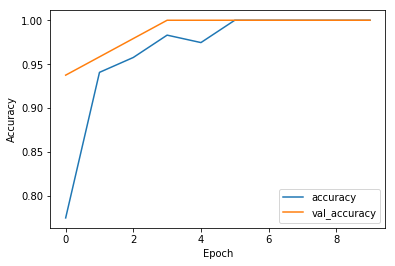

In [192]:
# plotting Accuracy
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

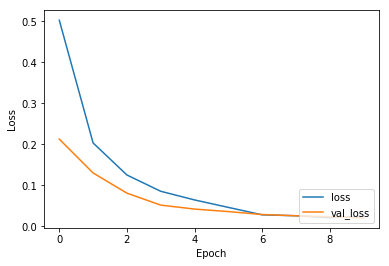

In [193]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [194]:
test_loss, test_acc = model.evaluate(testX,  testY)
# showing the predictions on the test images (14 positive images and 14 negative images)
Yhat=model.predict(testX)
for i in range(len(testX)):
    print("Test number ",i," Prediction: [",float(Yhat[i][0])," ",float(Yhat[i][1]),"] Label: ",testY[i]) 

28/28 [==============================] - 0s 3ms/sample - loss: 0.1037 - accuracy: 0.9643
Test number  0  Prediction: [ 0.9999806880950928   1.9279972548247315e-05 ] Label:  [1. 0.]
Test number  1  Prediction: [ 0.9995933175086975   0.0004066958208568394 ] Label:  [1. 0.]
Test number  2  Prediction: [ 0.9999607801437378   3.92712936445605e-05 ] Label:  [1. 0.]
Test number  3  Prediction: [ 0.9995726943016052   0.0004272889345884323 ] Label:  [1. 0.]
Test number  4  Prediction: [ 0.9999651908874512   3.484947592369281e-05 ] Label:  [1. 0.]
Test number  5  Prediction: [ 0.9999067783355713   9.319648233940825e-05 ] Label:  [1. 0.]
Test number  6  Prediction: [ 0.05995192378759384   0.9400480389595032 ] Label:  [1. 0.]
Test number  7  Prediction: [ 0.9197651743888855   0.08023485541343689 ] Label:  [1. 0.]
Test number  8  Prediction: [ 0.9999246597290039   7.527539855800569e-05 ] Label:  [1. 0.]
Test number  9  Prediction: [ 0.9999866485595703   1.340371909464011e-05 ] Label:  [1. 0.]
Test 

In [200]:
# Step 4: transfer learning with ResNet50
model3 = Sequential()
model3.add(ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
print("Model loaded")
# FC => dropout => FC => dropout => softmax on top of it
model3.add(layers.Flatten())
model3.add(layers.Dense(512,activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(512,activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(2,activation='softmax'))
# Disactivate training on resnet layers
for layer in restnet.layers:
    layer.trainable = False
model3.summary()
# using Adam optimizing algorithm with decaying learning rate
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model3.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history3 = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(ValidX, ValidY),
    validation_steps=len(ValidX) // BS,
    epochs=EPOCHS)

Model loaded
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_20 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)  

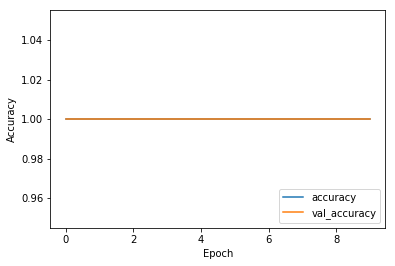

In [201]:
# plotting Accuracy
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

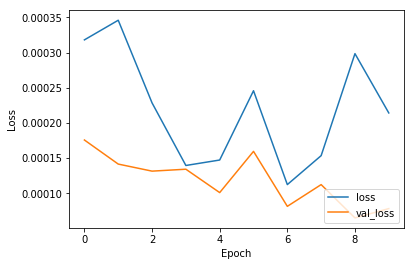

In [202]:
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [203]:
test_loss, test_acc = model.evaluate(testX,  testY)
# showing the predictions on the test images (14 positive images and 14 negative images)
Yhat=model.predict(testX)
for i in range(len(testX)):
    print("Test number ",i," Prediction: [",float(Yhat[i][0])," ",float(Yhat[i][1]),"] Label: ",testY[i]) 

28/28 [==============================] - 0s 3ms/sample - loss: 0.0115 - accuracy: 1.0000
Test number  0  Prediction: [ 1.0   1.120762860296054e-08 ] Label:  [1. 0.]
Test number  1  Prediction: [ 0.9999982118606567   1.732284886202251e-06 ] Label:  [1. 0.]
Test number  2  Prediction: [ 1.0   1.464367915815501e-08 ] Label:  [1. 0.]
Test number  3  Prediction: [ 0.9999979734420776   2.0256320567568764e-06 ] Label:  [1. 0.]
Test number  4  Prediction: [ 1.0   8.307178056554676e-09 ] Label:  [1. 0.]
Test number  5  Prediction: [ 0.9999998807907104   8.993758626729687e-08 ] Label:  [1. 0.]
Test number  6  Prediction: [ 0.7347374558448792   0.26526254415512085 ] Label:  [1. 0.]
Test number  7  Prediction: [ 0.9850446581840515   0.014955330640077591 ] Label:  [1. 0.]
Test number  8  Prediction: [ 0.9999998807907104   1.7840315535977425e-07 ] Label:  [1. 0.]
Test number  9  Prediction: [ 1.0   2.1151780327244296e-09 ] Label:  [1. 0.]
Test number  10  Prediction: [ 1.0   4.150722077156388e-08 ] 

In [ ]:
# Plotting all the 3 Neural network performances together
plt.plot(history1.history['loss'], label='loss_CNN')
plt.plot(history1.history['val_loss'], label = 'val_loss_CNN')
plt.plot(history2.history['loss'], label='loss_VGG16')
plt.plot(history2.history['val_loss'], label = 'val_loss_VGG16')
plt.plot(history3.history['loss'], label='loss_ResNet50')
plt.plot(history3.history['val_loss'], label = 'val_loss_ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

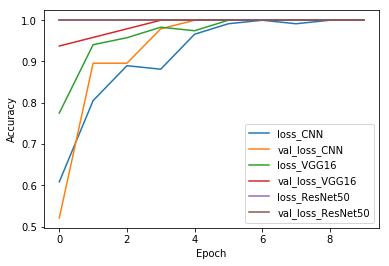

In [205]:
# Plotting all the 3 Neural network performances together
plt.plot(history1.history['accuracy'], label='loss_CNN')
plt.plot(history1.history['val_accuracy'], label = 'val_loss_CNN')
plt.plot(history2.history['accuracy'], label='loss_VGG16')
plt.plot(history2.history['val_accuracy'], label = 'val_loss_VGG16')
plt.plot(history3.history['accuracy'], label='loss_ResNet50')
plt.plot(history3.history['val_accuracy'], label = 'val_loss_ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')